In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import pandas as pd
import time
from concurrent.futures import ThreadPoolExecutor
from functools import partial
from google.colab import files

#Setting the parameters


In [2]:
#Parameters
n_steps, n_sim, n_MC, lam, T  = 95, 1, 10**4 , 2, 2

dict_parameters = {'delta' : T/n_steps,'sigma': 0.56, 'sigma_st': 0.31, 'sigma_0':0.31, 'theta':0.12, 'lam_0':2, 'lam':2, 'kappa' : np.exp(-lam/n_steps), 'h0' : 0, 'h1' :0, 'h2':100, 'A' : 150, 'C' : 80, 'K' : 50, 'pi':0.5, 'p0' :6.159423723, 'p1': 87.4286117, 'f0':0, 'f1':10**4, 
                   'q__0' : 0.26759617, 'R_0' : 2*0.12 , 'q_st' : 0.26759617, 'alpha_tg':-0.1 , 's0':-0.5}

delta, sigma,sigma_st, sigma_0, theta, lam_0, lam, kappa, h0, h1, h2, A, C, K, pi, p0, p1, f0, f1, q__0, R_0, q_st, alpha_tg, s0 = dict_parameters.values()


#Display or interactively change Parameters
parameters = pd.DataFrame(dict_parameters, index = ['value'])
parameters

,delta,sigma,sigma_st,sigma_0,theta,lam_0,lam,kappa,h0,h1,...,pi,p0,p1,f0,f1,q__0,R_0,q_st,alpha_tg,s0
value,0.021053,0.56,0.31,0.31,0.12,2,2,0.979167,0,0,...,0.5,6.159424,87.428612,0,10000,0.267596,0.24,0.267596,-0.1,-0.5


In [3]:
#time vector
t= np.arange(n_steps+1)
dict_parameters['t'] = t

#paper values
q_real = np.zeros(n_steps+1)

q_slzd = np.array([0.26759617, 0.24771933, 0.23588383, 0.221369, 0.21174, 0.2047625, 0.20651067, 0.20098083, 0.20826067, 0.22095067,
  0.24346833, 0.27283267, 0.3382265, 0.42920433, 0.4875495, 0.50948433, 0.487712, 0.4537295, 0.40911717, 0.3728925,
  0.347346, 0.3419715, 0.32684, 0.320009, 0.32065767, 0.32586567, 0.31492483, 0.31607417, 0.30411783, 0.29950567,
  0.307519, 0.33259367, 0.375465, 0.45608333, 0.599178,0.70970583, 0.7364855, 0.736731, 0.70612667, 0.67284583,
  0.66692767, 0.64925583, 0.604485, 0.55684567, 0.515597, 0.45097333, 0.3822625, 0.31841833])

# Use the same seasonality for 2 days
q_real[:48], q_real[48:n_steps+1] = q_slzd, q_slzd 
dict_parameters['q_real'] = q_real

#Compute mu
mu = np.zeros(n_steps+1)
mu[1:] = np.log(q_real[1:]/q__0)/(t[1:]*delta)
dict_parameters['mu'] = mu

#Creating the tree

In [4]:
#tree Matrice W for the Brownian Motion
def W_mat_tree(t):
  n_up = np.arange(t+1) 
  return np.sqrt(delta)*(2*n_up - t)

def compute_consumption(n_steps, dict_parameters):
  #parameters
  delta, sigma,sigma_st, sigma_0, theta, lam_0, lam, kappa, h0, h1, h2, A, C, K, pi, p0, p1, f0, f1, q__0, R_0, q_st, alpha_tg, s0,t,q_real,mu = dict_parameters.values()

  #Construct q_tree
  q_hat_tree = np.zeros((n_steps+1, n_steps+1))
  q_tree = np.zeros((n_steps + 1, n_steps+1, n_steps+1))
  for k in t:
    q_hat_tree[k][:k+1] = q_real[k]*np.exp((-(sigma_0**2)/2)*k*delta)*np.exp(sigma_0*W_mat_tree(k))
    q_tree[k][:k+1,:k+1] = q_real[k]*np.exp((-((sigma_0**2 + sigma**2)/2) )*k*delta)*np.exp(sigma_0*W_mat_tree(k) + sigma*W_mat_tree(k)[:,np.newaxis])
  return [q_hat_tree, q_tree]

#Q_tree
q_hat_tree, q_tree  = compute_consumption(n_steps, dict_parameters)


In [5]:
#R_tree (Approximation of the Real R)
#Build the process
def compute_R_tree(n_steps, dict_parameters):
  #Setting the parameters
  R_0, delta, t = dict_parameters['R_0'], dict_parameters['delta'], dict_parameters['t']

  #Construct the tree
  R_tree = np.zeros((n_steps+1, n_steps+1))
  R_tree[:,0] = R_0 + t*delta
  for i in range(1,n_steps+1):
    R_tree[i][1:i+1] = (i-t[1:i+1])*delta
  return R_tree

#Computing the tree of R, J, and K_theta
R_tree = compute_R_tree(n_steps, dict_parameters)
J_tree = (R_tree < theta)
K_theta = A+(1-pi)*p1+K+ f1*J_tree

In [6]:
#Ricatti BSDE for Phi (with polynomial roots)
def compute_Phi_hat_tree(n_steps, K_theta, dict_parameters):
  #parameters
  delta, sigma,sigma_st, sigma_0, theta, lam_0, lam, kappa, h0, h1, h2, A, C, K, pi, p0, p1, f0, f1, q__0, R_0, q_st, alpha_tg, s0,t,q_real,mu = dict_parameters.values()

  #Construct the solution of Ricatti
  Phi_tree = np.zeros((n_steps+1, n_steps+1))
  cond_exp_tree = np.zeros((n_steps+1, n_steps))

  #Backward computing
  Phi_tree[-1] = h2 + np.zeros(n_steps+1)

  for i in np.arange(n_steps-1,-1,-1):
    #Compute conditional expectation
    cond_exp_tree[i][:i+1] = (1-kappa)*Phi_tree[i+1][i+1] + kappa*Phi_tree[i+1][:i+1] 
    
    #solving the polynomial equation
    Phi_tree[i][:i+1] = (-1 + np.sqrt(1+4*delta*(1/K_theta[i][:i+1])*(cond_exp_tree[i][:i+1]+delta*C)))/(2*delta/K_theta[i][:i+1])
  return Phi_tree

Phi_hat_tree = compute_Phi_hat_tree(n_steps, K_theta, dict_parameters)

In [7]:
def compute_Psi_hat_tree(n_steps, K_theta, J_tree, q_hat_tree, dict_parameters):
  #Setting parameters
  delta, sigma,sigma_st, sigma_0, theta, lam_0, lam, kappa, h0, h1, h2, A, C, K, pi, p0, p1, f0, f1, q__0, R_0, q_st, alpha_tg, s0,t,q_real,mu = dict_parameters.values()

  #Construct the solution
  Psi_tree = np.zeros((n_steps+1, n_steps+1, n_steps+1))
  cond_exp_tree = np.zeros((n_steps+1, n_steps+1, n_steps))
  
  #Backward computing
  Psi_tree[-1] = h1 + np.zeros((n_steps+1,n_steps+1))

  for i in np.arange(n_steps-1,-1,-1):
    for j in range(i+1):
      #Compute conditional expectation
      cond_exp_tree[i][j][:i+1] = 0.5*((1-kappa)*(Psi_tree[i+1][j][i+1] + Psi_tree[i+1][j+1][i+1]) + kappa*(Psi_tree[i+1][j][:i+1] + Psi_tree[i+1][j+1][:i+1]))

      #solving fixed point principle
      Psi_tree[i][j][:i+1] = (cond_exp_tree[i][j][:i+1] - delta*Phi_hat_tree[i][:i+1]/K_theta[i][:i+1]*(p0+pi*p1*q_hat_tree[i][j]+((1-pi)*p1 + K)*q_hat_tree[i][j] + J_tree[i][:i+1]*(f0 + f1*((q_hat_tree[i][j]-q__0*np.exp(mu[i]*i*delta))-alpha_tg))))/(1+delta*Phi_hat_tree[i][:i+1]/K_theta[i][:i+1])
  return Psi_tree

Psi_hat_tree = compute_Psi_hat_tree(n_steps, K_theta, J_tree, q_hat_tree, dict_parameters)

#Simulation of random trajectories



In [8]:
# Simulating the increments
def simulate_increments(n_sim,n_MC, n_steps):
  #Common noise
  eps_0 = np.zeros((n_sim, n_MC, n_steps+1))
  eps_0[:,:, 1:] = np.random.binomial(1,1/2,size = (n_sim, n_MC, n_steps))   

  #Individual noise consumer 1
  eps_1 = np.zeros((n_sim,n_MC, n_steps+1))
  eps_1[:,:, 1:] = np.random.binomial(1,1/2,size = (n_sim, n_MC, n_steps))   

  #Individual noise consumer 2
  eps_2 = np.zeros((n_sim, n_MC, n_steps+1))
  eps_2[:,:, 1:] = np.random.binomial(1,1/2,size = (n_sim, n_MC, n_steps))   

  #Jumps
  eta_ =  np.zeros((n_sim, n_MC, n_steps+1))
  pssn_strd = np.random.binomial(1, kappa, size= (n_sim, n_MC, n_steps))                      
  eta_[:,:, 1:] = (kappa-1)*pssn_strd + kappa*(pssn_strd==0)
  return [eps_0, eps_1, eps_2, eta_]

def trajectories(eps_0,eps_1,eps_2,eta_):
  #time axis
  ax = eps_0.ndim-1

  #trajectory of the common noise
  trajectory_BM_0 = np.cumsum(eps_0, axis = ax)

  #trajectory of Individual noise consumer 1
  trajectory_BM_1 = np.cumsum(eps_1, axis = ax)

  #trajectory of Individual noise consumer 2
  trajectory_BM_2 = np.cumsum(eps_2, axis = ax)

  #trajectory of jumps
  idx = (eta_ == kappa)
  trajectory_Pois = np.zeros(eta_.shape)
  idx_0 = np.zeros((eta_.shape[0],eta_.shape[1]))
  for i in t:
    idx_0[idx[:,:,i] != 0] = i
    trajectory_Pois[:,:,i] = idx_0
  return [trajectory_BM_0.astype(int), trajectory_BM_1.astype(int), trajectory_BM_2.astype(int), trajectory_Pois.astype(int)]

#Simulating the increments for n_sim specific trajectories
eps_0, eps_1, eps_2, eta_ = simulate_increments(n_sim,1, n_steps)

In [9]:
#R
def compute_jumps(eta, delta, dict_parameters):
  #Setting the parameters
  lam_0 = dict_parameters['lam_0']
  R_0 = dict_parameters['R_0']
  n_sim, n_MC, n_plus = eta.shape
  n_steps = n_plus-1
  
  #Build the process
  R = R_0 + np.zeros((n_sim, n_MC, n_steps+1))

  #Euler Scheme
  for i in range(n_steps):
      R[:,:, i+1] = R[:,:,i] + delta*(1-lam_0*R[:,:,i]) - R[:,:,i]*eta[:,:,i+1] 
  return R

In [10]:
#All the simulations
def simulate_all_processes(eps_0, eps_1, eps_2, eta_, dict_parameters):
  #parameters
  theta, A, K, pi, p1, f1= dict_parameters['theta'], dict_parameters['A'], dict_parameters['K'], dict_parameters['pi'], dict_parameters['p1'], dict_parameters['f1']
  n_sim, n_MC, n_plus = eta_.shape
  n_steps = n_plus-1
  
  #trajectories
  trajectory = trajectories(eps_0, eps_1, eps_2, eta_)

  #Let's simulate
  #Compute R
  R_simulation = compute_jumps(eta_, delta, dict_parameters)

  #Compute K_theta
  K_simulation = A+(1-pi)*p1+K+f1*(R_simulation <= theta)

  #Simulation from the created trees
  Phi_hat_simulation,  Psi_hat_simulation, q_hat_simulation, q_simulation_1, q_simulation_2 = np.zeros((n_sim,n_MC, n_steps+1)), np.zeros((n_sim,n_MC, n_steps+1)), np.zeros((n_sim,n_MC, n_steps+1)), np.zeros((n_sim,n_MC, n_steps+1)), np.zeros((n_sim,n_MC, n_steps+1))
  for i in range(n_steps+1):
    q_hat_simulation[:,:,i] = q_hat_tree[i][trajectory[0][:,:,i]]
    q_simulation_1[:,:,i] = q_tree[i][trajectory[1][:,:,i], trajectory[0][:,:,i]] 
    q_simulation_2[:,:,i] = q_tree[i][trajectory[2][:,:,i], trajectory[0][:,:,i]]
    Phi_hat_simulation[:,:,i] = Phi_hat_tree[i][trajectory[3][:,:,i]]
    Psi_hat_simulation[:,:,i] = Psi_hat_tree[i][trajectory[0][:,:,i], trajectory[3][:,:,i]]

  return [R_simulation, K_simulation, q_hat_simulation, q_simulation_1, q_simulation_2, Phi_hat_simulation, Psi_hat_simulation]

#Simulating all the processes along said trajectories
R_simulation, K_simulation, q_hat_simulation, q_simulation_1, q_simulation_2, Phi_hat_simulation, Psi_hat_simulation = simulate_all_processes(eps_0, eps_1, eps_2, eta_, dict_parameters)


In [17]:
#let's compute alpha for one path
#Construct the solution
def compute_alpha_hat(R_simulation, K_simulation, q_hat_simulation, Phi_hat_simulation, Psi_hat_simulation, dict_parameters):

  #Setting the parameters
  n_sim, n_MC, n_plus = K_simulation.shape
  n_steps = n_plus-1
  s0, t, mu, delta = dict_parameters['s0'], dict_parameters['t'], dict_parameters['mu'], dict_parameters['delta']

  #Building S_hat
  S_hat = np.zeros((n_sim,n_MC, n_steps+1))
  S_hat[:,:,0] = s0

  for i in range(n_steps):
    S_hat[:,:,i+1] = S_hat[:,:,i] + delta*(- (1/K_simulation[:,:,i])*(p0+pi*p1*q_hat_simulation[:,:,i] + ((1-pi)*p1 + K)*q_hat_simulation[:,:,i] + Phi_hat_simulation[:,:,i]*S_hat[:,:,i] + Psi_hat_simulation[:,:,i] + (R_simulation[:,:,i] < theta)*(f0 + f1*((q_hat_simulation[:,:,i]-q__0*np.exp(mu[i]*i*delta))-alpha_tg))))
  
  #alpha hat
  alpha_hat = - (1/K_simulation)*(p0+pi*p1*q_hat_simulation + ((1-pi)*p1 + K)*q_hat_simulation + Phi_hat_simulation*S_hat + Psi_hat_simulation + (R_simulation < theta)*(f0 + f1*((q_hat_simulation-q__0*np.exp(mu*t*delta))-alpha_tg)))
  return alpha_hat
  #return S_hat

#Computing alpha_hat
alpha_hat = compute_alpha_hat(R_simulation, K_simulation, q_hat_simulation, Phi_hat_simulation, Psi_hat_simulation, dict_parameters)
#S_hat = compute_alpha_hat(R_simulation, K_simulation, q_hat_simulation, Phi_hat_simulation, Psi_hat_simulation, dict_parameters)

In [16]:
Psi_hat_simulation[0,0,0] + Phi_hat_simulation[0,0,0]*S_hat[0,0,0]

-107.78829732013304

#Unprojected case


In [18]:
# Unprojected Phi

def compute_phi_simulation(n_steps, dict_parameters):
  #Setting the parameters
  h2, A, K, C, delta = dict_parameters['h2'], dict_parameters['A'], dict_parameters['K'], dict_parameters['C'], dict_parameters['delta']

  #Construct the solution of Ricatti
  Phi = np.zeros(n_steps+1)
  
  #Backward computing
  Phi[-1] = h2
  
  for i in np.arange(n_steps-1,-1,-1):

    #solving the polynomial equation
    Phi[i] = (-1 + np.sqrt(1+4*delta*(1/(A+K))*(Phi[i+1]+delta*C)))/(2*delta/(A+K))

  return Phi

#Computing Phi_simulation
Phi_simulation = compute_phi_simulation(n_steps, dict_parameters)

In [19]:
def one_thread_compute_Psi(k, n_sim, n_iter, reste, n_sim_fragment, n_MC, n_steps, Psi_1, Psi_2, eps_0, eps_1, eps_2, eta_, Phi_simulation, dict_parameters):
    if k < n_iter or reste >0: # Case when reste == 0 is useless
        #Computing the integral at each time using Monte Carlo
        for i in range(n_steps):
          #visualizing progress
          if not i%25:
              print(int((i/n_steps)*100), '%')

          #treating the last case in a different way (when reste!=0)
          if k<n_iter: 
            n_sim = n_sim_fragment
            #Broadcasting 
            array_eps_0, array_eps_1, array_eps_2, array_eta_ = np.broadcast_to(eps_0[k*n_sim:(k+1)*n_sim], (n_sim,n_MC,n_steps+1)).copy(), np.broadcast_to(eps_1[k*n_sim:(k+1)*n_sim], (n_sim,n_MC,n_steps+1)).copy(), np.broadcast_to(eps_2[k*n_sim:(k+1)*n_sim], (n_sim,n_MC,n_steps+1)).copy(), np.broadcast_to(eta_[k*n_sim:(k+1)*n_sim], (n_sim,n_MC,n_steps+1)).copy()

          elif k == n_iter and reste>0:
            n_sim = reste
            #Broadcasting
            array_eps_0, array_eps_1, array_eps_2, array_eta_ = np.broadcast_to(eps_0[-n_sim:], (n_sim,n_MC,n_steps+1)).copy(), np.broadcast_to(eps_1[-n_sim:], (n_sim,n_MC,n_steps+1)).copy(), np.broadcast_to(eps_2[-n_sim:], (n_sim,n_MC,n_steps+1)).copy(), np.broadcast_to(eta_[-n_sim:], (n_sim,n_MC,n_steps+1)).copy()

          #Building the 4 possible paths by taking the same value for each simulation at the start
          eps_0_New, eps_1_New, eps_2_New, eta_New =  array_eps_0, array_eps_1, array_eps_2, array_eta_
          eps_0_New1, eps_1_New1, eps_2_New1, eta_New1 =  array_eps_0, array_eps_1, array_eps_2, array_eta_
          eps_0_New2, eps_1_New2, eps_2_New2, eta_New2 =  array_eps_0, array_eps_1, array_eps_2, array_eta_
          eps_0_New3, eps_1_New3, eps_2_New3, eta_New3 =  array_eps_0, array_eps_1, array_eps_2, array_eta_

          #Simulation of the truncated Monte Carlo random trajectories
          eps_0_trunc, eps_1_trunc, eps_2_trunc, eta_trunc = simulate_increments(n_sim,n_MC,n_steps-i)

          #Injecting the Monte Carlo trajectories in the 4 paths
          eps_0_New[:,:,i:], eps_1_New[:,:,i:], eps_2_New[:,:,i:], eta_New[:,:,i:] = eps_0_trunc, eps_1_trunc, eps_2_trunc, eta_trunc
          eps_0_New1[:,:,i:], eps_1_New1[:,:,i:], eps_2_New1[:,:,i:], eta_New1[:,:,i:] = eps_0_trunc==0, eps_1_trunc, eps_2_trunc, eta_trunc
          eps_0_New2[:,:,i:], eps_1_New2[:,:,i:], eps_2_New2[:,:,i:], eta_New2[:,:,i:] =  eps_0_trunc, eps_1_trunc==0, eps_2_trunc==0, eta_trunc
          eps_0_New3[:,:,i:], eps_1_New3[:,:,i:], eps_2_New3[:,:,i:], eta_New3[:,:,i:] = eps_0_trunc==0, eps_1_trunc==0, eps_2_trunc==0, eta_trunc 

          #Making sure of 0 at the start:
          eps_0_New1[:,:,0] = eps_1_New2[:,:,0] =  eps_2_New2[:,:,0] = eps_0_New3[:,:,0] = eps_1_New3[:,:,0] = eps_2_New3[:,:,0] = np.zeros((n_sim,n_MC))

          #Simulating all processes according to each new trajectory
          R_simulation_new, K_simulation_new, q_hat_simulation_new, q_simulation_1_new, q_simulation_2_new, Phi_hat_simulation_new, Psi_hat_simulation_new = simulate_all_processes(eps_0_New, eps_1_New, eps_2_New, eta_New, dict_parameters)
          R_simulation_new1, K_simulation_new1, q_hat_simulation_new1, q_simulation_1_new1, q_simulation_2_new1, Phi_hat_simulation_new1, Psi_hat_simulation_new1 = simulate_all_processes(eps_0_New1, eps_1_New1, eps_2_New1, eta_New1, dict_parameters)
          R_simulation_new2, K_simulation_new2, q_hat_simulation_new2, q_simulation_1_new2, q_simulation_2_new2, Phi_hat_simulation_new2, Psi_hat_simulation_new2 = simulate_all_processes(eps_0_New2, eps_1_New2, eps_2_New2, eta_New2, dict_parameters)
          R_simulation_new3, K_simulation_new3, q_hat_simulation_new3, q_simulation_1_new3, q_simulation_2_new3, Phi_hat_simulation_new3, Psi_hat_simulation_new3 = simulate_all_processes(eps_0_New3, eps_1_New3, eps_2_New3, eta_New3, dict_parameters)

          #Computing each alpha_hat
          alpha_hat_new  = compute_alpha_hat(R_simulation_new, K_simulation_new, q_hat_simulation_new, Phi_hat_simulation_new, Psi_hat_simulation_new, dict_parameters)
          alpha_hat_new1 = compute_alpha_hat(R_simulation_new1, K_simulation_new1, q_hat_simulation_new1, Phi_hat_simulation_new1, Psi_hat_simulation_new1, dict_parameters)
          alpha_hat_new2 = compute_alpha_hat(R_simulation_new2, K_simulation_new2, q_hat_simulation_new2, Phi_hat_simulation_new2, Psi_hat_simulation_new2, dict_parameters)
          alpha_hat_new3 = compute_alpha_hat(R_simulation_new3, K_simulation_new3, q_hat_simulation_new3, Phi_hat_simulation_new3, Psi_hat_simulation_new3, dict_parameters)

          #Building the 4 possible integrals for each agent
          I, I1, I2, I3 = np.zeros((n_sim, n_MC,n_steps)), np.zeros((n_sim, n_MC,n_steps)), np.zeros((n_sim, n_MC,n_steps)), np.zeros((n_sim, n_MC,n_steps))
          I_2, I1_2, I2_2, I3_2 = np.zeros((n_sim, n_MC,n_steps)), np.zeros((n_sim, n_MC,n_steps)), np.zeros((n_sim, n_MC,n_steps)), np.zeros((n_sim, n_MC,n_steps))

          #Integral for trajectory number 1
          P_simulation = K*q_simulation_1_new[:,:,i:] + p0+pi*p1*q_hat_simulation_new[:,:,i:]+(1-pi)*p1*(q_hat_simulation_new[:,:,i:] + alpha_hat_new[:,:,i:]) + (R_simulation_new[:,:,i:] <= theta)*(f0 + f1*(q_hat_simulation_new[:,:,i:]-q__0*np.exp(mu[i:]*t[i:]*delta)+ alpha_hat_new[:,:,i:] -alpha_tg))
          I[:,:,i] = np.sum((Phi_simulation[i:]/(A+K))*np.exp((-np.cumsum(Phi_simulation[t[i:]])/(A + K))*delta)*P_simulation*delta, axis=2)

          P_simulation_2 = K*q_simulation_2_new[:,:,i:] + p0+pi*p1*q_hat_simulation_new[:,:,i:]+(1-pi)*p1*(q_hat_simulation_new[:,:,i:] + alpha_hat_new[:,:,i:]) + (R_simulation_new[:,:,i:] <= theta)*(f0 + f1*(q_hat_simulation_new[:,:,i:]-q__0*np.exp(mu[i:]*t[i:]*delta)+ alpha_hat_new[:,:,i:] -alpha_tg))
          I_2[:,:,i] = np.sum((Phi_simulation[i:]/(A+K))*np.exp((-np.cumsum(Phi_simulation[t[i:]])/(A + K))*delta)*P_simulation_2*delta, axis =2)

          #Integral for trajectory number 2
          P_simulation1 = K*q_simulation_1_new1[:,:,i:] + p0+pi*p1*q_hat_simulation_new1[:,:,i:]+(1-pi)*p1*(q_hat_simulation_new1[:,:,i:] + alpha_hat_new1[:,:,i:]) + (R_simulation_new1[:,:,i:] <= theta)*(f0 + f1*(q_hat_simulation_new1[:,:,i:]-q__0*np.exp(mu[i:]*t[i:]*delta)+ alpha_hat_new1[:,:,i:] -alpha_tg))
          I1[:,:,i] = np.sum((Phi_simulation[i:]/(A+K))*np.exp((-np.cumsum(Phi_simulation[t[i:]])/(A + K))*delta)*P_simulation1*delta, axis =2)

          P_simulation1_2 = K*q_simulation_2_new1[:,:,i:] + p0+pi*p1*q_hat_simulation_new1[:,:,i:]+(1-pi)*p1*(q_hat_simulation_new1[:,:,i:] + alpha_hat_new1[:,:,i:]) + (R_simulation_new1[:,:,i:] <= theta)*(f0 + f1*(q_hat_simulation_new1[:,:,i:]-q__0*np.exp(mu[i:]*t[i:]*delta)+ alpha_hat_new1[:,:,i:] -alpha_tg))
          I1_2[:,:,i] = np.sum((Phi_simulation[i:]/(A+K))*np.exp((-np.cumsum(Phi_simulation[t[i:]])/(A + K))*delta)*P_simulation1_2*delta, axis =2)

          #Integral for trajectory number 3
          P_simulation2 = K*q_simulation_1_new2[:,:,i:] + p0+pi*p1*q_hat_simulation_new2[:,:,i:]+(1-pi)*p1*(q_hat_simulation_new2[:,:,i:] + alpha_hat_new2[:,:,i:]) + (R_simulation_new2[:,:,i:] <= theta)*(f0 + f1*(q_hat_simulation_new2[:,:,i:]-q__0*np.exp(mu[i:]*t[i:]*delta)+ alpha_hat_new2[:,:,i:] -alpha_tg))
          I2[:,:,i] = np.sum((Phi_simulation[i:]/(A+K))*np.exp((-np.cumsum(Phi_simulation[t[i:]])/(A + K))*delta)*P_simulation2*delta, axis =2)

          P_simulation2_2 = K*q_simulation_2_new2[:,:,i:] + p0+pi*p1*q_hat_simulation_new2[:,:,i:]+(1-pi)*p1*(q_hat_simulation_new2[:,:,i:] + alpha_hat_new2[:,:,i:]) + (R_simulation_new2[:,:,i:] <= theta)*(f0 + f1*(q_hat_simulation_new2[:,:,i:]-q__0*np.exp(mu[i:]*t[i:]*delta)+ alpha_hat_new2[:,:,i:] -alpha_tg))
          I2_2[:,:,i] = np.sum((Phi_simulation[i:]/(A+K))*np.exp((-np.cumsum(Phi_simulation[t[i:]])/(A + K))*delta)*P_simulation2_2*delta, axis =2)

          #Integral for trajectory number 4
          P_simulation3 = K*q_simulation_1_new3[:,:,i:] + p0+pi*p1*q_hat_simulation_new3[:,:,i:]+(1-pi)*p1*(q_hat_simulation_new3[:,:,i:] + alpha_hat_new3[:,:,i:]) + (R_simulation_new3[:,:,i:] <= theta)*(f0 + f1*(q_hat_simulation_new3[:,:,i:]-q__0*np.exp(mu[i:]*t[i:]*delta)+ alpha_hat_new3[:,:,i:] -alpha_tg))
          I3[:,:,i] = np.sum((Phi_simulation[i:]/(A+K))*np.exp((-np.cumsum(Phi_simulation[t[i:]])/(A + K))*delta)*P_simulation3*delta, axis =2)

          P_simulation3_2 = K*q_simulation_2_new3[:,:,i:] + p0+pi*p1*q_hat_simulation_new3[:,:,i:]+(1-pi)*p1*(q_hat_simulation_new3[:,:,i:] + alpha_hat_new3[:,:,i:]) + (R_simulation_new3[:,:,i:] <= theta)*(f0 + f1*(q_hat_simulation_new3[:,:,i:]-q__0*np.exp(mu[i:]*t[i:]*delta)+ alpha_hat_new3[:,:,i:] -alpha_tg))
          I3_2[:,:,i] = np.sum((Phi_simulation[i:]/(A+K))*np.exp((-np.cumsum(Phi_simulation[t[i:]])/(A + K))*delta)*P_simulation3_2*delta, axis =2)

          final_integral = 0.25*(I[:,:,i] + I1[:,:,i] + I2[:,:,i] + I3[:,:,i])
          final_integral_2 = 0.25*(I_2[:,:,i] + I1_2[:,:,i] + I2_2[:,:,i] + I3_2[:,:,i])

          #treating the last case in a different way (when reste !=0)
          if k<n_iter:

            #Monte Carlo
            Psi_1[k*n_sim:(k+1)*n_sim,i] = h1*np.exp((-np.sum(Phi_simulation[i:-1])/(A + K))*delta) - np.mean(final_integral, axis = 1)
            Psi_2[k*n_sim:(k+1)*n_sim,i] = h1*np.exp((-np.sum(Phi_simulation[i:-1])/(A + K))*delta) - np.mean(final_integral_2, axis = 1)

          elif k == n_iter and reste>0:

            #Monte Carlo
            Psi_1[-n_sim:,i] = h1*np.exp((-np.sum(Phi_simulation[i:-1])/(A + K))*delta) - np.mean(final_integral, axis = 1)
            Psi_2[-n_sim:,i] = h1*np.exp((-np.sum(Phi_simulation[i:-1])/(A + K))*delta) - np.mean(final_integral_2, axis = 1)

In [20]:
def compute_Psi_simulation(n_MC, eps_0, eps_1, eps_2, eta_, Phi_simulation, R_simulation, K_simulation, q_hat_simulation, q_simulation_1, q_simulation_2, Phi_hat_simulation, Psi_hat_simulation, alpha_hat, dict_parameters):
  #setting the parameters:
  n_sim, n_steps = eta_.shape[0], eta_.shape[2]-1
  delta, sigma,sigma_st, sigma_0, theta, lam_0, lam, kappa, h0, h1, h2, A, C, K, pi, p0, p1, f0, f1, q__0, R_0, q_st, alpha_tg, s0,t,q_real,mu = dict_parameters.values()

  #Construct the solution
  #Agent 1
  Psi_1 = np.zeros((n_sim, n_steps+1))

  #Agent 2
  Psi_2 = np.zeros((n_sim, n_steps+1))

  #Backward computing
  Psi_1[:,-1] = h1
  Psi_2[:,-1] = h1

  #Solving RAM problem by fragmentating the matrices:
  n_sim_fragment = 10**5//n_MC 
  n_iter = n_sim // (n_sim_fragment)
  print('number of iterations=', n_iter)
  reste = n_sim % (n_sim_fragment)
  print('remaining simulations=',reste)

  with ThreadPoolExecutor(4) as ex:
    list_idx = [k for k in range(n_iter+1)]
    partial_func = partial(one_thread_compute_Psi, n_sim = n_sim, n_iter = n_iter, reste = reste, n_sim_fragment = n_sim_fragment, n_MC = n_MC, n_steps = n_steps, Psi_1 = Psi_1, Psi_2 = Psi_2, eps_0 = eps_0 , eps_1=eps_1, eps_2 = eps_2, eta_ = eta_, Phi_simulation = Phi_simulation, dict_parameters =dict_parameters) 
    p = ex.map(partial_func, list_idx)
  return [Psi_1, Psi_2]

#Compute Psi_1 and Psi_2 (Agent 1 and Agent 2)
y1 = time.time()
Psi_1, Psi_2 = compute_Psi_simulation(n_MC, eps_0, eps_1, eps_2, eta_, Phi_simulation, R_simulation, K_simulation, q_hat_simulation, q_simulation_1, q_simulation_2, Phi_hat_simulation, Psi_hat_simulation, alpha_hat, dict_parameters)
y2 = time.time()
print(y2 -y1)

number of iterations= 0
remaining simulations= 1
0 %
26 %
52 %
78 %
150.74644827842712


In [21]:
#Computing alpha
def compute_alpha(eps_0, eps_1, eps_2, eta_, R_simulation, K_simulation, q_hat_simulation, q_simulation_1, q_simulation_2, Phi_hat_simulation, Psi_hat_simulation, alpha_hat, Phi_simulation, Psi_1, Psi_2, dict_parameters):
  #Setting the parameters
  n_sim, n_MC, n_plus = eta_.shape
  n_steps = n_plus-1
  s0, t, mu, delta = dict_parameters['s0'], dict_parameters['t'], dict_parameters['mu'], dict_parameters['delta']
  
  #Construct the solution
  S1 = np.zeros((n_sim, n_steps+1))
  S2 = np.zeros((n_sim, n_steps+1))

  #Initial condition
  S1[:,0] = s0
  S2[:,0] = s0

  #SDE scheme
  for i in range(n_steps):
    S1[:,i+1] = S1[:,i] + delta*(- (1/(A+K))*(K*q_simulation_1[:,0,i] + p0+pi*p1*q_hat_simulation[:,0,i] + (1-pi)*p1*(q_hat_simulation[:,0,i]+alpha_hat[:,0,i]) + Phi_simulation[i]*S1[:,i] + Psi_1[:,i]+ (f0+f1*(q_hat_simulation[:,0,i] - q__0*np.exp(mu[i]*i*delta) + alpha_hat[:,0,i] -alpha_tg))*(R_simulation[:,0,i] <= theta)))
    S2[:,i+1] = S2[:,i] + delta*(- (1/(A+K))*(K*q_simulation_2[:,0,i] + p0+pi*p1*q_hat_simulation[:,0,i] + (1-pi)*p1*(q_hat_simulation[:,0,i]+alpha_hat[:,0,i]) + Phi_simulation[i]*S2[:,i] + Psi_2[:,i]+ (f0+f1*(q_hat_simulation[:,0,i] - q__0*np.exp(mu[i]*i*delta) + alpha_hat[:,0,i] -alpha_tg))*(R_simulation[:,0,i] <= theta)))
  
  alpha_1 = - (1/(A+K))*(K*q_simulation_1[:,0,:] + p0+pi*p1*q_hat_simulation[:,0,:] + (1-pi)*p1*(q_hat_simulation[:,0,:] + alpha_hat[:,0,:]) + Phi_simulation*S1+ Psi_1 + (f0+f1*(q_hat_simulation[:,0,:] - q__0*np.exp(mu*t*delta) + alpha_hat[:,0,:] -alpha_tg))*(R_simulation[:,0,:] <= theta))
  alpha_2 = - (1/(A+K))*(K*q_simulation_2[:,0,:] + p0+pi*p1*q_hat_simulation[:,0,:] + (1-pi)*p1*(q_hat_simulation[:,0,:] + alpha_hat[:,0,:]) + Phi_simulation*S2+ Psi_2 + (f0+f1*(q_hat_simulation[:,0,:] - q__0*np.exp(mu*t*delta) + alpha_hat[:,0,:] -alpha_tg))*(R_simulation[:,0,:] <= theta))
  return [alpha_1, alpha_2]
  #return [S1,S2]

#Compute alpha_1 and alpha_2 (Agent 1 and Agent2)
#Solving RAM problem by fragmentating the matrices:
alpha_1,alpha_2 = compute_alpha(eps_0, eps_1, eps_2, eta_, R_simulation, K_simulation, q_hat_simulation, q_simulation_1, q_simulation_2, Phi_hat_simulation, Psi_hat_simulation, alpha_hat, Phi_simulation, Psi_1, Psi_2, dict_parameters)
#S1,S2 = compute_alpha(eps_0, eps_1, eps_2, eta_, R_simulation, K_simulation, q_hat_simulation, q_simulation_1, q_simulation_2, Phi_hat_simulation, Psi_hat_simulation, alpha_hat, Phi_simulation, Psi_1, Psi_2, dict_parameters)

In [26]:
Psi_1[:,0] + S1[:,0]*Phi_simulation[0]
Psi_2[:,0] + S2[:,0]*Phi_simulation[0]

array([-107.72396967])

In [ ]:
#Compute the price
def price(p0, p1, q, alpha, pi):
  return p0+pi*p1*q + (1-pi)*p1*(q+alpha)
  
p = price(p0, p1,q_hat_simulation, alpha_hat, pi)
p_no_alpha = price(p0, p1,q_hat_simulation, 0, pi)

pi_list = [0.1, 0.5, 0.9]

#Plots

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

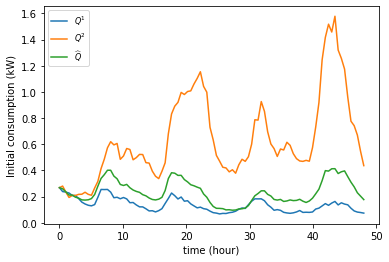

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

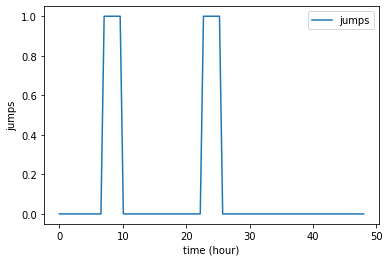

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

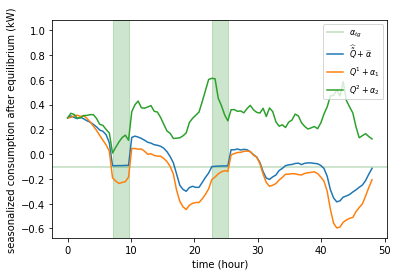

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

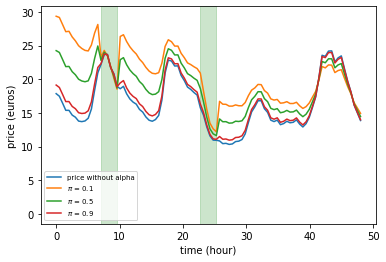

In [ ]:
'''Plotting simulation number:''' 
k = 100

#Plots
plt.plot(t*delta*24, q_simulation_1[k][0], label = r'$Q^{1}$')
plt.plot(t*delta*24, q_simulation_2[k][0], label = r'$Q^{2}$')
plt.plot(t*delta*24, q_hat_simulation[k][0], label = r'$\widehat{Q}$')
plt.xlabel('time (hour)')
plt.ylabel('Initial consumption (kW)')
plt.legend(loc = 2, prop = {'size': 8})
plt.savefig(f'trajectory_MC {k}.png')
files.download(f'trajectory_MC {k}.png')
plt.show()
plt.plot(t*delta*24, R_simulation[k][0] < theta, label = 'jumps')
plt.xlabel('time (hour)')
plt.ylabel('jumps')
plt.legend()
plt.savefig(f'jump_MC {k}.png')
files.download(f'jump_MC {k}.png')
plt.show()
fig, ax = plt.subplots() 
ax.fill_between(t*delta*24, 0, 1, where= R_simulation[k][0]<theta,
              color='green', alpha=0.2, transform=ax.get_xaxis_transform())
ax.axhline(alpha_tg, color='green', label= r'$\alpha_{tg}$', lw=2, alpha=0.2)
ax.plot(t*delta*24,alpha_hat[k][0] + q_hat_simulation[k][0] - q_real, label = r'$\widehat{\tilde{Q}} + \widehat{\alpha}$')
ax.plot(t*delta*24,alpha_1[k] + q_simulation_1[k][0] - q_real, label = r'$Q^{1} + \alpha_{1}$')
ax.plot(t*delta*24,alpha_2[k] + q_simulation_2[k][0] - q_real, label = r'$Q^{2} + \alpha_{2}$')
plt.xlabel('time (hour)')
plt.ylabel('seasonalized consumption after equilibrium (kW)')
plt.legend(loc=1, prop={'size': 8})
plt.savefig(f'target_MC {k}.png')
files.download(f'target_MC {k}.png')
plt.show()
fig, ax = plt.subplots() 
ax.fill_between(t*delta*24, 0, 1, where= R_simulation[k][0]<theta,
              color='green', alpha=0.2, transform=ax.get_xaxis_transform())
ax.plot(t*delta*24,p_no_alpha[k][0], label = 'price without alpha')
for pi in pi_list:
  ax.plot(t*delta*24,price(p0, p1, q_hat_simulation, alpha_hat, pi)[k][0], label = f'$\pi$ = {pi}')
  plt.xlabel('time (hour)')
  plt.ylabel('price (euros)')
  plt.legend( prop={'size': 7})
plt.savefig(f'price_MC {k}.png')
files.download(f'price_MC {k}.png')
plt.show()

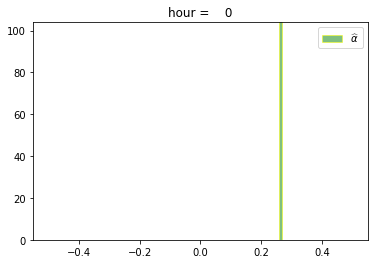

In [ ]:
#Plotting the moving histogram for big n_sim (>200)
# Fixing random state for reproducibility
np.random.seed(19680801)
# Fixing bin edges
HIST_BINS = np.linspace(-0.5, 0.5, 100)

# histogram our data with numpy
data = alpha_hat[:,0,0]
n, _ = np.histogram(data, HIST_BINS, density = True)

def prepare_animation(bar_container):
    def animate(frame_number):
        # simulate new data coming in
        data = alpha_hat[:,0:,frame_number]
        n, _ = np.histogram(data, HIST_BINS)
        for count, rect in zip(n, bar_container):
            rect.set_height(count)
        txt_title.set_text('hour = {0:4d}'.format(int(frame_number*delta*24)))
        return bar_container
    return animate

fig, ax = plt.subplots()
_, _, bar_container = ax.hist(data, HIST_BINS, lw=1,
                              ec="yellow", fc="green", alpha=0.5, density=True)
#ax.set_ylim(top=100)  # set safe limit to ensure that all data is visible.
txt_title = ax.set_title('')
ani = animation.FuncAnimation(fig, prepare_animation(bar_container), 95, interval = 50,
                              repeat=True, blit=True)
ax.legend([r'$\widehat{\alpha}$'])
plt.show()
HTML(ani.to_html5_video())

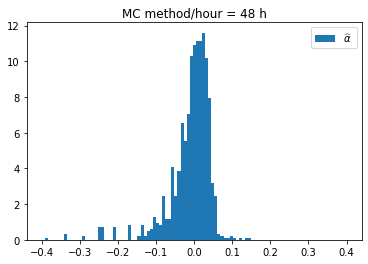

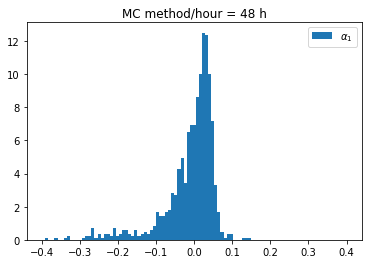

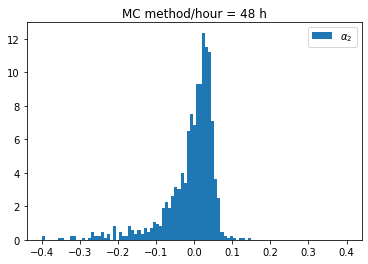

In [ ]:
#Histograms of alpha_hat, alpha_1, alpha_2 at fixed times
HIST_BINS = np.linspace(-0.4, 0.4, 100)

#time in hours
time_ = 48

#Plots
plt.hist(alpha_hat[:,0,int(time_/(24*delta))], HIST_BINS, density = True, label = r'$\widehat{\alpha}$')
plt.title(label = f'MC method/hour = {time_} h')
plt.legend()
plt.show()
plt.hist(alpha_1[:,int(time_/(24*delta))], HIST_BINS, density = True, label = r'$\alpha_{1}$')
plt.title(label = f'MC method/hour = {time_} h')
plt.legend()
plt.show()
plt.hist(alpha_2[:,int(time_/(24*delta))], HIST_BINS, density = True, label = r'$\alpha_{2}$')
plt.title(label = f'MC method/hour = {time_} h')
plt.legend()
plt.show()

#Computation time

In [ ]:
list_n_MC = [100,150,200,500,1000]
list_n_sim = [1,10,100,1000]
def compute_time_(n_steps, list_n_sim, list_n_MC, dict_parameters):
    dict_time = {}
    for k in list_n_sim:
      col = []
      eps_0, eps_1, eps_2, eta_ = simulate_increments(k,1, n_steps)
      for n in list_n_MC:
        t2 = time.time()
        compute_Psi_simulation(n, eps_0, eps_1, eps_2, eta_, Phi_simulation, R_simulation, K_simulation, q_hat_simulation, q_simulation_1, q_simulation_2, Phi_hat_simulation, Psi_hat_simulation, alpha_hat, dict_parameters)
        t3 = time.time()
        col.append(t3-t2)
      dict_time[f'Comp time (s) for {k} sim'] = col
    return pd.DataFrame(dict_time, index = list_n_MC)

df = compute_time_(n_steps, list_n_sim , list_n_MC, dict_parameters)
print(df)
df.to_csv('output.csv', encoding = 'utf-8-sig') 
files.download('output.csv')

number of iterations= 0
remaining simulations= 1
0 %
26 %
52 %
78 %
number of iterations= 0
remaining simulations= 1
0 %
26 %
52 %
78 %
number of iterations= 0
remaining simulations= 1
0 %
26 %
52 %
78 %
number of iterations= 0
remaining simulations= 1
0 %
26 %
52 %
78 %
number of iterations= 0
remaining simulations= 1
0 %
26 %
52 %
78 %
number of iterations= 0
remaining simulations= 10
0 %
26 %
52 %
78 %
number of iterations= 0
remaining simulations= 10
0 %
26 %
52 %
78 %
number of iterations= 0
remaining simulations= 10
0 %
26 %
52 %
78 %
number of iterations= 0
remaining simulations= 10
0 %
26 %
52 %
78 %
number of iterations= 0
remaining simulations= 10
0 %
26 %
52 %
78 %
number of iterations= 0
remaining simulations= 100
0 %
26 %
52 %
78 %
number of iterations= 0
remaining simulations= 100
0 %
26 %
52 %
78 %
number of iterations= 0
remaining simulations= 100
0 %
26 %
52 %
78 %
number of iterations= 0
remaining simulations= 100
0 %
26 %
52 %
78 %
number of iterations= 1
remaining s

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#tree time
def compute_tree_time(n_steps, n_sim, dict_parameters):
    eps_0, eps_1, eps_2, eta_ = simulate_increments(n_sim,1, n_steps)
    dict_time = {} 

    t0 = time.time()
    compute_Psi_hat_tree(n_steps, K_theta, J_tree, q_hat_tree, dict_parameters)
    t1 = time.time()

    t2 = time.time()
    compute_Phi_hat_tree(n_steps, K_theta, dict_parameters)
    t3 = time.time() 

    t4 = time.time()
    compute_consumption(n_steps, dict_parameters)
    t5 = time.time()

    t6 = time.time()
    compute_R_tree(n_steps, dict_parameters)
    t7 = time.time()
    
    dict_time['Q_tree '] = t5 - t4
    dict_time['R_tree '] = t7 - t6
    dict_time['Phi_Tree '] = t3-t2
    dict_time['Psi_tree '] = t1 -t0
    return pd.DataFrame(dict_time, index = ['Computation time (sec)'])

compute_tree_time(n_steps, 1, dict_parameters)

,Q_tree,R_tree,Phi_Tree,Psi_tree
Computation time (sec),0.019648,0.000494,0.002133,0.225045


#Saving the Data

In [ ]:
#Saving data
dict_data = {'eps_0' : eps_0[:,0,:], 'eps_1' : eps_1[:,0,:], 'eps_2' : eps_2[:,0,:], 'eta_' : eta_[:,0,:], 'alpha_hat' : alpha_hat[:,0,:], 'R_simulation' : R_simulation[:,0,:], 'Phi_simulation' : Phi_simulation, 'q_hat_simulation' :q_hat_simulation[:,0,:],'q_simulation_1' :q_simulation_1[:,0,:], 'q_simulation_2' :q_simulation_2[:,0,:], 'alpha_1' : alpha_1, 'alpha_2' : alpha_2}

for key, value in dict_data.items():
  np.savetxt(f'{key}.csv', value, delimiter=',')
  files.download(f'{key}.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Loading data
#Uploading files
uploaded = files.upload()

Saving alpha_2.csv to alpha_2.csv
Saving alpha_1.csv to alpha_1.csv
Saving q_simulation_2.csv to q_simulation_2.csv
Saving q_simulation_1.csv to q_simulation_1.csv
Saving q_hat_simulation.csv to q_hat_simulation.csv
Saving R_simulation.csv to R_simulation.csv
Saving alpha_hat.csv to alpha_hat.csv
Saving eta_.csv to eta_.csv
Saving eps_2.csv to eps_2.csv
Saving eps_1.csv to eps_1.csv
Saving eps_0.csv to eps_0.csv
Saving Phi_simulation.csv to Phi_simulation.csv


In [ ]:
list_names = ['eps_0', 'eps_1', 'eps_2', 'eta_', 'alpha_hat', 'R_simulation', 'Phi_simulation', 'q_hat_simulation', 'q_simulation_1', 'q_simulation_2', 'alpha_1', 'alpha_2']

alpha_hat = np.loadtxt('alpha_hat.csv', delimiter=',')[:,None,:]    
R_simulation = np.loadtxt('R_simulation.csv', delimiter=',')[:,None,:]
Phi_simulation = np.loadtxt('Phi_simulation.csv', delimiter=',')
q_hat_simulation = np.loadtxt('q_hat_simulation.csv', delimiter=',')[:,None,:]
q_simulation_1 = np.loadtxt('q_simulation_1.csv', delimiter=',')[:,None,:]
q_simulation_2 = np.loadtxt('q_simulation_2.csv', delimiter=',')[:,None,:]
alpha_1 = np.loadtxt('alpha_1.csv', delimiter=',')
alpha_2 = np.loadtxt('alpha_2.csv', delimiter=',')